In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random, time
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# set to ignore warning
pd.set_option('mode.chained_assignment', None)

# set random seed
np.random.seed(2)

In [2]:
# load spread data
spread = pd.read_csv('../Data/NFL_Spread_Data_Pre2020.csv')

In [3]:
# use OrdinalEncoder to transform team and opp to numeric value
ord_enc = OrdinalEncoder()
spread['team_code'] = ord_enc.fit_transform(spread[['team']])
spread.team_code = spread.team_code.astype(int)
spread['opp_code'] = ord_enc.fit_transform(spread[['opp']])
spread.opp_code = spread.opp_code.astype(int)
Codes = spread[['team', 'team_code', 'opp', 'opp_code']]

In [4]:
# drop 'Team' and 'Opp' since they are now encoded
spread.drop(['team', 'opp'], axis = 1, inplace = True)
spread.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,spread_outcome,over/under,team_code,opp_code
0,2010,2,2,0,0,0,0,7,7,1,...,1.0,0.0,1.0,1.0,0.0,13.0,0,43.0,3,11
1,2010,3,3,0,0,0,0,7,7,1,...,0.0,1.0,0.0,0.0,2.0,14.5,1,43.0,3,21
2,2010,4,4,0,0,0,0,7,7,0,...,2.0,0.0,2.0,0.0,2.0,6.0,0,37.0,3,24
3,2010,5,5,0,0,0,0,7,7,0,...,1.0,0.0,1.0,0.0,1.0,-2.5,0,41.5,3,14
4,2010,7,6,0,0,1,0,14,7,1,...,0.0,0.0,0.0,1.0,0.0,12.5,1,40.0,3,2


In [5]:
# seperate features and target
# X is feature matrix
X = spread.drop(['spread_outcome'], axis = 1)

# y is target
y = spread['spread_outcome']

In [6]:
# normalize data using StandardScaler
scaler = StandardScaler()
names = X.columns
d = scaler.fit_transform(X)
scaled_df = pd.DataFrame(d, columns = names)
scaled_df.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
0,-1.565545,-1.611285,-1.615738,-0.339493,-0.818726,-0.266525,-0.266525,-0.222030,-0.22203,1.0,...,-0.638259,-0.047329,-0.730691,0.110760,0.098361,-0.713795,2.051351,-0.457587,-1.357202,-0.489469
1,-1.565545,-1.399152,-1.384699,-0.339493,-0.818726,-0.266525,-0.266525,-0.222030,-0.22203,1.0,...,-0.067307,-0.660117,0.110296,-0.718875,-0.722603,0.849963,2.288045,-0.457587,-1.357202,0.595197
2,-1.565545,-1.187019,-1.153661,-0.339493,-0.818726,-0.266525,-0.266525,-0.222030,-0.22203,-1.0,...,-0.638259,0.565458,-0.730691,0.940396,-0.722603,0.849963,0.946777,-1.862818,-1.357202,0.920597
3,-1.565545,-0.974886,-0.922622,-0.339493,-0.818726,-0.266525,-0.266525,-0.222030,-0.22203,-1.0,...,-0.638259,-0.047329,-0.730691,0.110760,-0.722603,0.068084,-0.394491,-0.808895,-1.357202,-0.164069
4,-1.565545,-0.550620,-0.691583,-0.339493,-0.818726,3.751989,-0.266525,3.117909,-0.22203,1.0,...,-0.067307,-0.660117,-0.730691,-0.718875,0.098361,-0.713795,1.972453,-1.160203,-1.357202,-1.465669


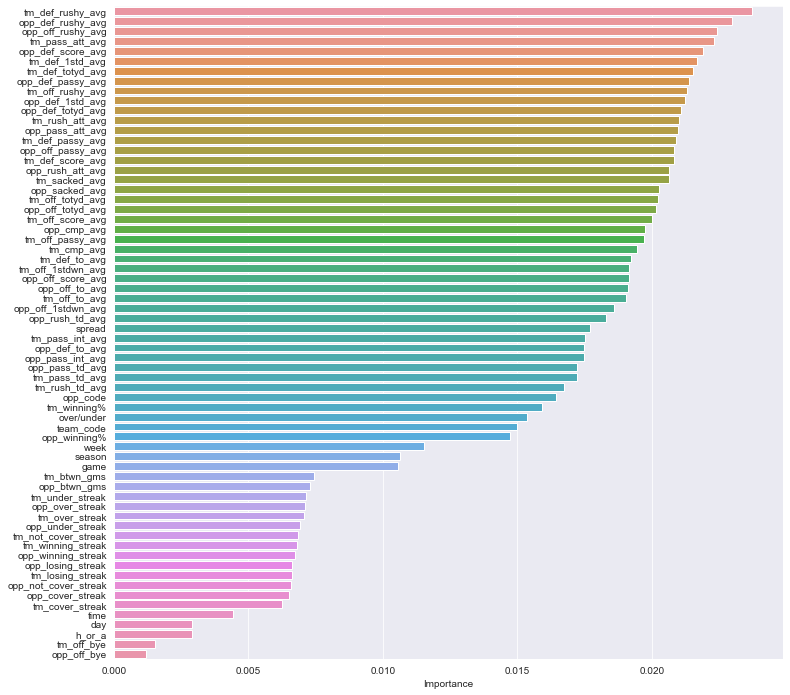

In [7]:
# visual of important features
clf = RandomForestClassifier()

model = clf.fit(X,y)

feat_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns = ['Importance'])
feat_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

sns.set_style('darkgrid')
plt.figure(figsize=(12,12))
sns.barplot(y = feat_importances.index, x = feat_importances.Importance)
plt.show()

In [8]:
# top features (all with importance of 0.15 or higher)
top_feat = []
for i in range(len(feat_importances)):
    if feat_importances['Importance'][i] > 0.015:
        top_feat.append(feat_importances['Importance'].index[i])
        
print(top_feat)

['tm_def_rushy_avg', 'opp_def_rushy_avg', 'opp_off_rushy_avg', 'tm_pass_att_avg', 'opp_def_score_avg', 'tm_def_1std_avg', 'tm_def_totyd_avg', 'opp_def_passy_avg', 'tm_off_rushy_avg', 'opp_def_1std_avg', 'opp_def_totyd_avg', 'tm_rush_att_avg', 'opp_pass_att_avg', 'tm_def_passy_avg', 'opp_off_passy_avg', 'tm_def_score_avg', 'opp_rush_att_avg', 'tm_sacked_avg', 'opp_sacked_avg', 'tm_off_totyd_avg', 'opp_off_totyd_avg', 'tm_off_score_avg', 'opp_cmp_avg', 'tm_off_passy_avg', 'tm_cmp_avg', 'tm_def_to_avg', 'tm_off_1stdwn_avg', 'opp_off_score_avg', 'opp_off_to_avg', 'tm_off_to_avg', 'opp_off_1stdwn_avg', 'opp_rush_td_avg', 'spread', 'tm_pass_int_avg', 'opp_def_to_avg', 'opp_pass_int_avg', 'opp_pass_td_avg', 'tm_pass_td_avg', 'tm_rush_td_avg', 'opp_code', 'tm_winning%', 'over/under']


In [9]:
# review correlations
corr = X.corr()
corr

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
season,1.000000e+00,-1.487104e-02,-0.009830,1.613824e-02,2.140587e-02,-0.000243,-0.000243,-0.002566,-0.002566,1.216276e-15,...,0.001166,0.011469,-0.000616,0.007459,0.037948,-0.050850,3.741855e-14,1.320404e-01,-0.000421,-0.000421
week,-1.487104e-02,1.000000e+00,0.997776,1.043185e-01,-1.604227e-02,-0.033859,-0.033859,-0.012484,-0.012484,-7.054362e-18,...,0.113831,0.102013,0.060502,0.068216,0.129537,0.047247,8.650778e-17,-3.931182e-02,-0.000050,-0.000050
game,-9.829991e-03,9.977763e-01,1.000000,1.052090e-01,-1.586849e-02,-0.061368,-0.039518,-0.033009,-0.016877,-1.433487e-03,...,0.112372,0.100304,0.061231,0.066922,0.127760,0.047395,5.381973e-04,-3.890340e-02,-0.000939,-0.000553
day,1.613824e-02,1.043185e-01,0.105209,1.000000e+00,4.007306e-01,-0.068773,-0.068773,-0.334153,-0.334153,8.697252e-18,...,0.006702,0.029961,0.017659,-0.003316,0.012647,0.002947,-2.282539e-17,1.147045e-02,0.009062,0.009062
time,2.140587e-02,-1.604227e-02,-0.015868,4.007306e-01,1.000000e+00,0.000051,0.000051,-0.065865,-0.065865,4.651780e-17,...,-0.074354,0.085365,-0.012753,0.010993,-0.016117,-0.003252,-4.492322e-17,1.240993e-01,0.056254,0.056254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_over_streak,-5.084972e-02,4.724713e-02,0.047395,2.946969e-03,-3.251561e-03,-0.014793,0.032935,-0.014495,0.039141,-1.622642e-02,...,-0.025026,0.031822,-0.010886,0.009113,-0.515790,1.000000,3.446073e-02,1.388952e-01,0.008086,0.021368
spread,3.741855e-14,8.650778e-17,0.000538,-2.282539e-17,-4.492322e-17,-0.011193,0.011193,-0.011058,0.011058,3.486439e-01,...,-0.281626,0.266895,-0.156980,0.144722,-0.020177,0.034461,1.000000e+00,-8.323594e-16,-0.017908,0.017908
over/under,1.320404e-01,-3.931182e-02,-0.038903,1.147045e-02,1.240993e-01,0.018591,0.018591,0.019629,0.019629,-5.086912e-17,...,-0.101078,0.113401,-0.008294,0.046879,-0.143686,0.138895,-8.323594e-16,1.000000e+00,0.018953,0.018953
team_code,-4.211552e-04,-4.992984e-05,-0.000939,9.062451e-03,5.625367e-02,-0.002044,0.019592,-0.002889,0.026597,5.662357e-03,...,-0.000072,-0.005774,0.003908,0.002982,-0.016631,0.008086,-1.790842e-02,1.895327e-02,1.000000,-0.069352


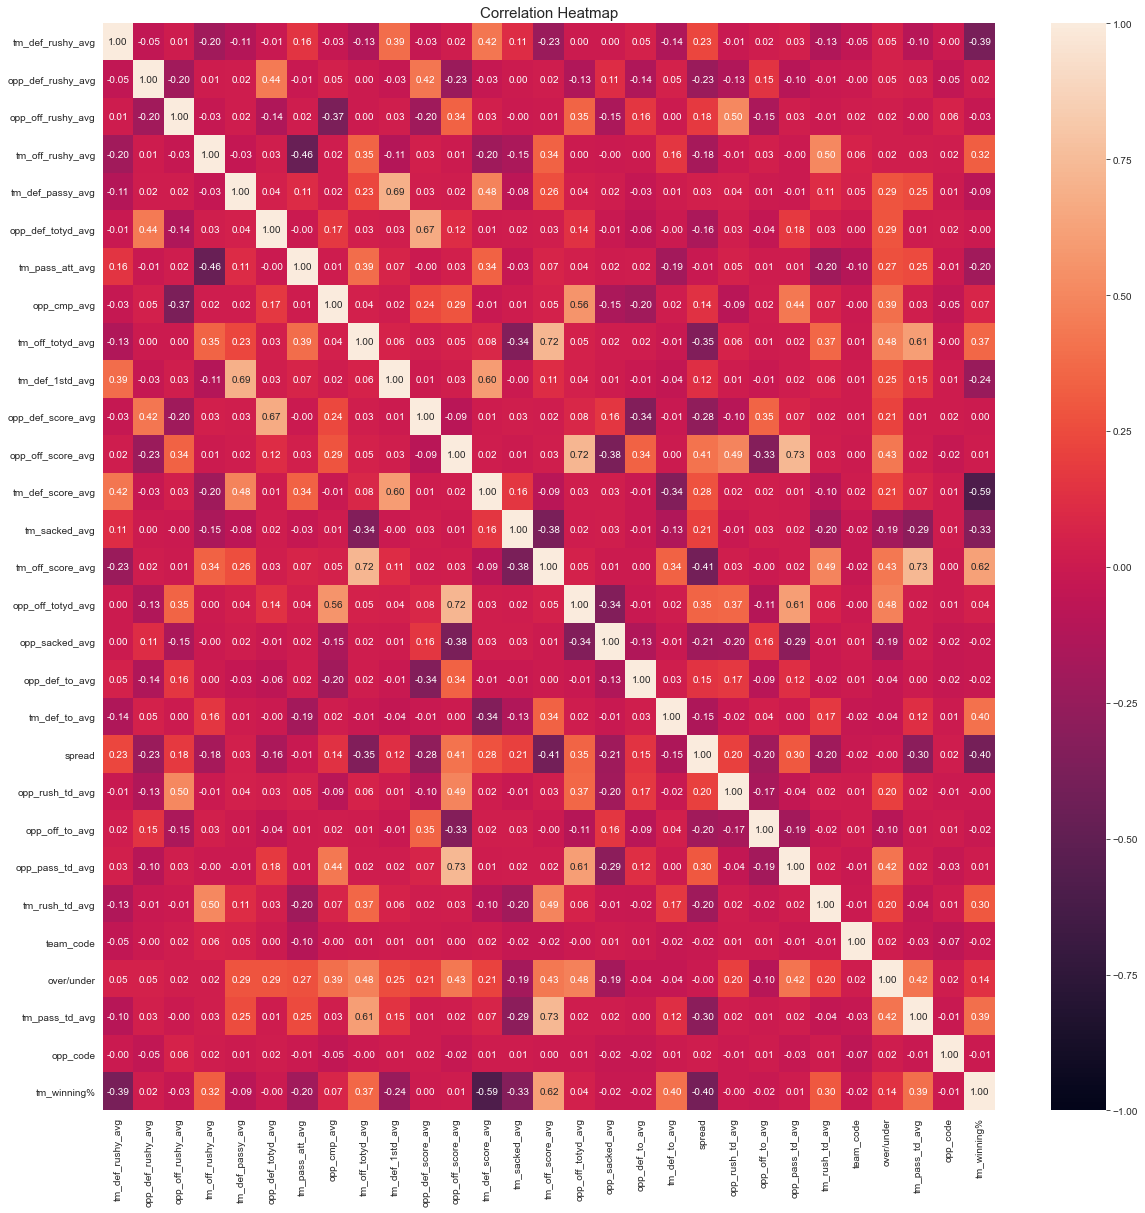

In [10]:
# further refine feature set
clean_up_more = X[['tm_def_rushy_avg', 'opp_def_rushy_avg', 'opp_off_rushy_avg', 'tm_off_rushy_avg', 'tm_def_passy_avg',
                   'opp_def_totyd_avg', 'tm_pass_att_avg', 'opp_cmp_avg', 'tm_off_totyd_avg', 'tm_def_1std_avg',
                   'opp_def_score_avg', 'opp_off_score_avg', 'tm_def_score_avg', 'tm_sacked_avg', 'tm_off_score_avg',
                   'opp_off_totyd_avg', 'opp_sacked_avg', 'opp_def_to_avg', 'tm_def_to_avg', 'spread', 'opp_rush_td_avg',
                   'opp_off_to_avg', 'opp_pass_td_avg', 'tm_rush_td_avg', 'team_code', 'over/under', 'tm_pass_td_avg',
                   'opp_code', 'tm_winning%']]
         
clean_corr = clean_up_more.corr()
                  
# correlation heat map of new features
plt.figure(figsize = (20,20))
sns.heatmap(clean_corr, vmin = -1, vmax =1, annot = True, fmt = '.2f')
plt.title('Correlation Heatmap', fontdict = {'fontsize':15})
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

new_top_feat = clean_up_more.columns

In [11]:
# Set X as features data
X = scaled_df[new_top_feat]
X.head()

,tm_def_rushy_avg,opp_def_rushy_avg,opp_off_rushy_avg,tm_off_rushy_avg,tm_def_passy_avg,opp_def_totyd_avg,tm_pass_att_avg,opp_cmp_avg,tm_off_totyd_avg,tm_def_1std_avg,...,spread,opp_rush_td_avg,opp_off_to_avg,opp_pass_td_avg,tm_rush_td_avg,team_code,over/under,tm_pass_td_avg,opp_code,tm_winning%
0,0.898039,1.586858,0.819012,-2.201442,-1.811742,-0.628157,-0.235885,-0.853578,-3.741860,-0.381136,...,2.051351,0.546431,0.774869,0.708721,-1.797635,-1.357202,-0.457587,-0.914738,-0.489469,-1.89384
1,0.067405,0.067405,-0.912224,-0.838554,-0.710489,0.729242,-1.891384,0.115847,-3.537257,-0.571444,...,2.288045,-1.797635,-0.006991,1.520450,-0.625602,-1.357202,-0.457587,-1.726467,0.595197,-1.89384
2,1.262708,-1.951780,0.843569,-0.261475,-0.424083,-0.270563,-1.753426,-1.869167,-2.186875,0.253227,...,0.946777,-1.016280,-1.831333,0.708721,-1.016280,-1.357202,-1.862818,-0.914738,0.920597,-1.89384
3,2.599827,-0.358042,0.726925,-0.157110,-0.728642,1.227320,-1.736181,-1.130557,-2.284061,0.665563,...,-0.394491,-0.625602,0.383939,-0.103008,-1.211619,-1.357202,-0.808895,-0.508873,-0.164069,-1.89384
4,2.940185,-0.175708,0.063899,-0.123959,-0.940421,-1.492951,-1.601672,-0.345784,-2.002732,0.608470,...,1.972453,0.546431,-0.006991,-0.644161,-1.328822,-1.357202,-1.160203,0.059337,-1.465669,-1.89384


In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

# number of samples in each set
print('Samples in training set:', X_train.shape[0])
print('Samples in testing set:', X_test.shape[0])

Samples in training set: 3739
Samples in testing set: 935


In [13]:
# Evaluation of models using Confusion Matrix, Precision, Recall, F1 Score
# simple function for calculating and displaying metrics
def model_metrics(m):
    print('Train mean accuracy:', round(cross_val_score(m, X_train, y_train, cv = 10, scoring = 'accuracy').mean(), 4))
    print('Test mean accuracy:', round(cross_val_score(m, X_test, y_test, cv = 10, scoring = 'accuracy').mean(), 4))
    print('')
    print(classification_report(y_test, m.predict(X_test), zero_division = 0))
    cm = confusion_matrix(y_test, m.predict(X_test))
    plt.figure(figsize=(10, 5))
    heatmap = sns.heatmap(cm, annot = True, fmt = "d", annot_kws={"size": 20},
                cbar = False, cmap = 'Blues_r', 
                xticklabels = ['Not Covered', 'Covered'], yticklabels = ['Not Covered', 'Covered'])
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 15)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 15, rotation = 0)
    plt.show()

In [14]:
# Random Forest
# Create the parameter grid
param_grid = {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf': [2, 3, 4, 5], 
              'min_samples_split': [2, 4, 6,], 'n_estimators': [100, 200, 300, 400, 500]}

# Create a based model
rf = RandomForestClassifier(random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.498513 using {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
Execution time: 1263.5563733577728 ms


Train mean accuracy: 0.4913
Test mean accuracy: 0.4986

              precision    recall  f1-score   support

           0       0.47      0.52      0.49       443
           1       0.52      0.47      0.49       492

    accuracy                           0.49       935
   macro avg       0.49      0.49      0.49       935
weighted avg       0.49      0.49      0.49       935



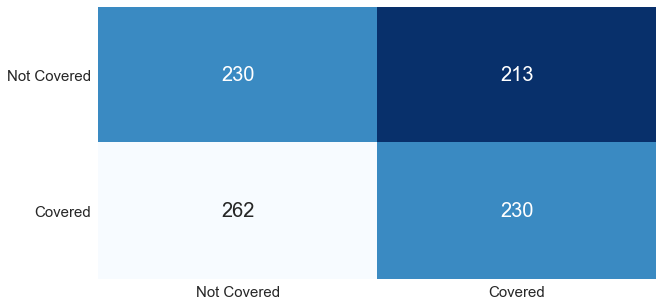

In [15]:
clf_rf_spread = RandomForestClassifier(bootstrap = True, max_depth = None, 
                                       min_samples_leaf = 2, min_samples_split = 6, n_estimators = 100)  
clf_rf_spread = clf_rf_spread.fit(X_train, y_train)
model_metrics(clf_rf_spread)

# dump the trained random forest classifier with Pickle
file = '..\\Pickles\\clf_rf_spread.pkl'

# open the file to save as pkl file
clf_rf_spread_pkl = open(file, 'wb')
pickle.dump(clf_rf_spread, clf_rf_spread_pkl)

# close the pickle instances
clf_rf_spread_pkl.close()

In [16]:
# Logistic Regression
# Create the parameter grid
param_grid = {'dual': [True, False], 'max_iter': [100, 200, 300, 500, 1000], 'C': [1.0, 1.5, 2.0, 2.5, 3.0]}

# Create a based model
lr = LogisticRegression(penalty = 'l2', random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.498525 using {'C': 2.0, 'dual': False, 'max_iter': 100}
Execution time: 1.5946226119995117 ms


Train mean accuracy: 0.4985
Test mean accuracy: 0.4953

              precision    recall  f1-score   support

           0       0.47      0.58      0.52       443
           1       0.52      0.41      0.46       492

    accuracy                           0.49       935
   macro avg       0.49      0.49      0.49       935
weighted avg       0.50      0.49      0.49       935



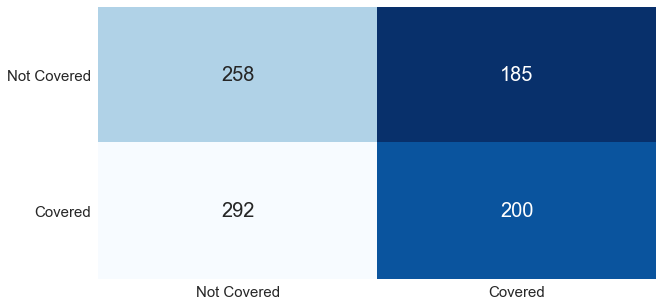

In [22]:
clf_log_reg_spread = LogisticRegression(C = 2.0, dual = False, max_iter = 100)
clf_log_reg_spread = clf_log_reg_spread.fit(X_train, y_train)
model_metrics(clf_log_reg_spread)

# dump the trained logistic regression classifier with Pickle
file = '..\\Pickles\\clf_log_reg_spread.pkl'

# open the file to save as pkl file
clf_log_reg_spread_pkl = open(file, 'wb')
pickle.dump(clf_log_reg_spread, clf_log_reg_spread_pkl)

# close the pickle instances
clf_log_reg_spread_pkl.close()

Best k value is 3


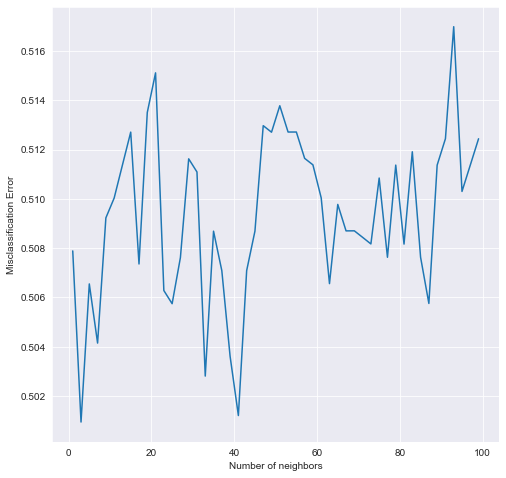

In [18]:
# K Nearest Neighbor
# Perform 10 fold cross validation
neighbors = []
cv_scores = []

for k in range(1, 100, 2):
    np.random.seed(50)
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

# Misclassification error versus k
MSE = [1-x for x in cv_scores]

# Determine the best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('Best k value is', optimal_k)

# Plot misclassification error versus k
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors, MSE)
plt.xlabel('Number of neighbors')
plt.ylabel('Misclassification Error')
plt.show()

Train mean accuracy: 0.4991
Test mean accuracy: 0.5113

              precision    recall  f1-score   support

           0       0.48      0.51      0.49       443
           1       0.54      0.51      0.52       492

    accuracy                           0.51       935
   macro avg       0.51      0.51      0.51       935
weighted avg       0.51      0.51      0.51       935



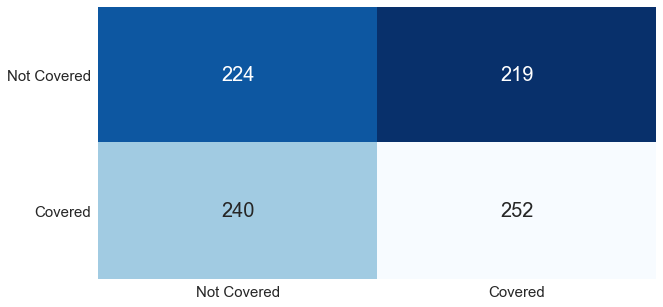

In [19]:
knn_spread = KNeighborsClassifier(n_neighbors = optimal_k)
knn_spread = knn_spread.fit(X_train, y_train)
model_metrics(knn_spread)

# dump the trained KNN classifier with Pickle
file = '..\\Pickles\\knn_spread.pkl'

# open the file to save as pkl file
knn_spread_pkl = open(file, 'wb')
pickle.dump(knn_spread, knn_spread_pkl)

# close the pickle instances
knn_spread_pkl.close()

Train mean accuracy: 0.4905
Test mean accuracy: 0.5028

              precision    recall  f1-score   support

           0       0.49      0.51      0.50       443
           1       0.54      0.52      0.53       492

    accuracy                           0.51       935
   macro avg       0.51      0.51      0.51       935
weighted avg       0.51      0.51      0.51       935



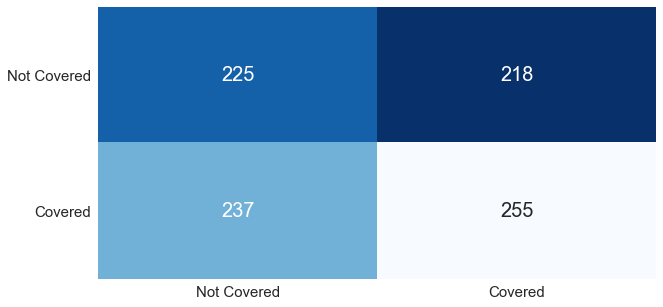

In [20]:
# Gaussian Classifier
clf_gnb_spread = GaussianNB()
clf_gnb_spread = clf_gnb_spread.fit(X_train, y_train)
model_metrics(clf_gnb_spread)

# dump the trained gaussian classifier with Pickle
file = '..\\Pickles\\clf_gnb_spread.pkl'

# open the file to save as pkl file
clf_gnb_spread_pkl = open(file, 'wb')
pickle.dump(clf_gnb_spread, clf_gnb_spread_pkl)

# close the pickle instances
clf_gnb_spread_pkl.close()